In [27]:
import torch

if torch.cuda.is_available():

    device = 'cuda'
else:

    device = 'cpu'
    
print(device)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())

cuda
1
Tesla T4


In [28]:
!pip install transformers

In [0]:
import pandas as pd

dfx = pd.read_csv('./imdb.csv',engine = 'python',encoding='utf-8', error_bad_lines=False).fillna("none")

In [30]:
dfx.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB


In [31]:
dfx.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [0]:
 dfx.sentiment = dfx.sentiment.apply(       #把positive、negetive映射为1、0
        lambda x: 1 if x == "positive" else 0       #DataFrame的apply方法
    )

In [0]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Sentiment Analysis')

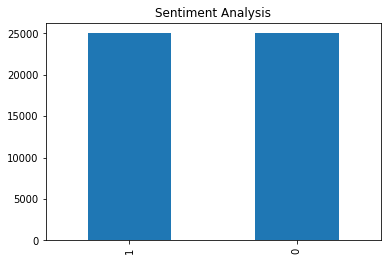

In [34]:
dfx['sentiment'].value_counts().plot.bar()       #对于标签一般用柱状图化
plt.title("Sentiment Analysis")

In [35]:
dfx['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

Text(0.5, 1.0, 'Analysis Sentence Length')

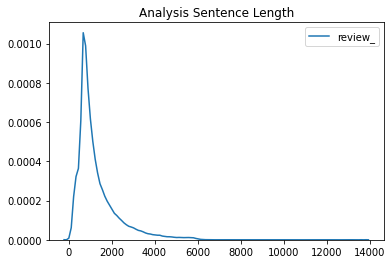

In [36]:
import seaborn as sns

dfx['review_'] = dfx['review'].astype(str).apply(len)   #当使用apply(len)该方法时，可以获取列的长度#们需要在DataFrame类型的数据中通过切片获得我们所需要的数据，然后转换为我们所需要的类型
sns.kdeplot(dfx['review_'])   #kdeplot核密度估计图                         #Dataframe数据类型的转换需要用到astype函数
plt.title('Analysis Sentence Length')       #通过核密度估计图可以比较直观的看出数据样本本身的分布特征    

In [0]:
import torch
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [0]:
MAX_LEN = 512

In [0]:
class BERTDataset:      #写一个处理数据得到ids,tasks,token_type_ids,targets
 
    def __init__(self, review, target):
        self.review = review      
        self.target = target                #标签
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')     #实例化切词器
        self.max_len = MAX_LEN         #给出要切的长度
    
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, item):      #取一条条数据（此时还没有batch_size的概念）
        review = str(self.review[item])     #转化为str   str() 函数将对象转化为适于人阅读的形式
        review = " ".join(review.split())   # 以空格为分隔符，包含 \n #返回通过指定字符连接序列中元素后生成的新字符串

        inputs = self.tokenizer.encode_plus(        #拿到review后对review做处理
            review,
            None,     #text_pair = None
            add_special_tokens=True,
            max_length=self.max_len
        )
    
     
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
     

        padding_length = self.max_len - len(ids)
        ids = ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.target[item], dtype=torch.float)      #标签
        }

In [0]:
import torch
import torch.nn as nn
from tqdm import tqdm

In [0]:
class BERTBaseUncased(nn.Module):   
    def __init__(self):         
        super(BERTBaseUncased, self).__init__()   
        self.bert = BertModel.from_pretrained('bert-base-uncased')    
        self.bert_drop = nn.Dropout(0.3)    
        self.out = nn.Linear(768, 1)   
      
    def forward(self, ids, mask, token_type_ids): 
        _, o2 = self.bert(                  
            ids, 
            attention_mask=mask,      
            token_type_ids=token_type_ids
        )

        bo = self.bert_drop(o2)     #取到pooler_output后进行Dropout
        output = self.out(bo)           #对dropout后进行全链接表示为1维（即2种状态0和1）[8,1]
        return output                     #现在这个输出是线性的，它将产生一个数字(分类预测值)


In [0]:
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))  #view函数的作用为重构张量的维度，相当于numpy中resize（）的功能

def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()

    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):    #data_loader是可迭代对象

        ids = d["ids"]       
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]    #标签也要拿(计算误差的时候要用到)
        

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(         #调用模型返回预测值(用三个得到预测的)
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs, targets)    #criterion损失函数  可以写成 criterion = nn.BCEWithLogitsLoss 
        print(loss.item()) 
        loss.backward()                     #criterion(outputs, targets)
        optimizer.step()
        scheduler.step()


In [0]:
def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():       #with torch.no_grad()将所有requires_grad标志临时设置为false #不需要反向传播
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)    
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            
            outputs = model(           #[bacth_size,1]
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            fin_targets.extend(targets.cpu().detach().numpy().tolist())    #Numpy 中 tolist()用于将数组或矩阵转为列表。
            
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())   #转化为概率
            
    return fin_outputs, fin_targets

In [0]:
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1

In [0]:
#import config
#import dataset
#import engine
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
#from model import BERTBaseUncased
from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

def run():
    dfx = pd.read_csv('./imdb.csv',engine = 'python',encoding='utf-8', error_bad_lines=False).fillna("none")  #将NAN值转换为0 #使用指定的方法填充NA / NaN值
    dfx.sentiment = dfx.sentiment.apply(       #把positive、negetive映射为1、0
        lambda x: 1 if x == "positive" else 0       #DataFrame的apply方法
    )

    df_train, df_valid = model_selection.train_test_split(   #因为只有一个数据集，所以把他拆分为训练集和验证集
        dfx,
        test_size=0.1,
        random_state=42,
        stratify=dfx.sentiment.values    #按情感值划分
    )

    df_train = df_train.reset_index(drop=True)     # 重置所有的索引 #reset_index的作用是重新设置dataframe的index，范围为0~len（df）
    df_valid = df_valid.reset_index(drop=True)     #drop：預設為True，刪除用作新索引的列

    train_dataset = BERTDataset(
        review=df_train.review.values,       #把拿到的df_train放入BERTDataset类中
        target=df_train.sentiment.values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=4
    )

    valid_dataset = BERTDataset(
        review=df_valid.review.values,
        target=df_valid.sentiment.values
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=1
    )

    device = torch.device("cuda")
    model = BERTBaseUncased()
    model.to(device)
    
    param_optimizer = list(model.named_parameters())  

    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    #model = nn.DataParallel(model)


    best_accuracy = 0
    for epoch in range(EPOCHS):
        print(f"EPOCH:{epoch}")
        train_fn(train_data_loader, model, optimizer, device, scheduler)
        outputs, targets = eval_fn(valid_data_loader, model, device)
        print("outputs:",outputs)
        print("targets:",targets)
        outputs = np.array(outputs) >= 0.5
        print("========outputs:",outputs)
        accuracy = metrics.accuracy_score(targets, outputs)  #y_true, y_pred
        print(f"Accuracy Score = {accuracy}")
        if accuracy > best_accuracy:
            if not os.path.isdir('./save_path'):
              os.mkdir('./save_path')
            torch.save(model.state_dict(), 'save_path/model.pth')
            best_accuracy = accuracy

In [0]:
run()

EPOCH:0



  0%|          | 0/11250 [00:00<?, ?it/s]

0.4141048491001129



  0%|          | 1/11250 [00:00<1:59:37,  1.57it/s]

1.1309423446655273



  0%|          | 2/11250 [00:01<1:47:20,  1.75it/s]

1.048488736152649



  0%|          | 3/11250 [00:01<1:39:39,  1.88it/s]

0.6384724378585815



  0%|          | 4/11250 [00:01<1:33:09,  2.01it/s]

1.064133644104004



  0%|          | 5/11250 [00:02<1:29:35,  2.09it/s]

0.7616029381752014



  0%|          | 6/11250 [00:02<1:26:50,  2.16it/s]

0.4447961449623108



  0%|          | 7/11250 [00:03<1:24:46,  2.21it/s]

0.7987380027770996



  0%|          | 8/11250 [00:03<1:23:47,  2.24it/s]

0.9630500078201294



  0%|          | 9/11250 [00:04<1:22:40,  2.27it/s]

0.5475162267684937



  0%|          | 10/11250 [00:04<1:21:34,  2.30it/s]

0.7429773807525635



  0%|          | 11/11250 [00:04<1:21:22,  2.30it/s]

0.6234051585197449



  0%|          | 12/11250 [00:05<1:21:07,  2.31it/s]

0.6894574165344238



  0%|          | 13/11250 [00:05<1:21:18,  2.30it/s]

0.6737184524536133



  0%|          | 14/11250 [00:06<1:21:01,  2.31it/s]

0.7939656972885132



  0%|          | 15/11250 [00:06<1:20:52,  2.32it/s]

0.6407893896102905



  0%|          | 16/11250 [00:07<1:21:27,  2.30it/s]

0.7199426889419556



  0%|          | 17/11250 [00:07<1:21:05,  2.31it/s]

0.7352112531661987



  0%|          | 18/11250 [00:07<1:20:58,  2.31it/s]

0.6249340772628784



  0%|          | 19/11250 [00:08<1:21:01,  2.31it/s]

0.6858228445053101



  0%|          | 20/11250 [00:08<1:20:51,  2.31it/s]

0.6771717071533203



  0%|          | 21/11250 [00:09<1:22:29,  2.27it/s]

0.5833366513252258



  0%|          | 22/11250 [00:09<1:22:07,  2.28it/s]

0.6342180967330933



  0%|          | 23/11250 [00:10<1:21:16,  2.30it/s]

0.6637606620788574



  0%|          | 24/11250 [00:10<1:20:50,  2.31it/s]

0.7951698899269104



  0%|          | 25/11250 [00:10<1:20:21,  2.33it/s]

0.7004938125610352



  0%|          | 26/11250 [00:11<1:20:00,  2.34it/s]

0.4890263080596924



  0%|          | 27/11250 [00:11<1:19:55,  2.34it/s]

0.71798175573349



  0%|          | 28/11250 [00:12<1:19:59,  2.34it/s]

0.572959303855896



  0%|          | 29/11250 [00:12<1:20:13,  2.33it/s]

0.6746788620948792



  0%|          | 30/11250 [00:13<1:20:28,  2.32it/s]

0.7207668423652649



  0%|          | 31/11250 [00:13<1:20:05,  2.33it/s]

0.539286732673645



  0%|          | 32/11250 [00:13<1:20:00,  2.34it/s]

0.7153133153915405



  0%|          | 33/11250 [00:14<1:20:30,  2.32it/s]

0.6612719297409058



  0%|          | 34/11250 [00:14<1:20:33,  2.32it/s]

0.6346400380134583



  0%|          | 35/11250 [00:15<1:20:46,  2.31it/s]

0.6465110182762146



  0%|          | 36/11250 [00:15<1:20:45,  2.31it/s]

0.4501732885837555



  0%|          | 37/11250 [00:16<1:20:24,  2.32it/s]

0.593215823173523



  0%|          | 38/11250 [00:16<1:19:57,  2.34it/s]

0.6047738790512085



  0%|          | 39/11250 [00:16<1:20:37,  2.32it/s]

0.44947749376296997



  0%|          | 40/11250 [00:17<1:20:38,  2.32it/s]

0.797139585018158



  0%|          | 41/11250 [00:17<1:20:42,  2.31it/s]

0.6805351972579956



  0%|          | 42/11250 [00:18<1:20:49,  2.31it/s]

0.33450472354888916



  0%|          | 43/11250 [00:18<1:20:47,  2.31it/s]

1.316330075263977



  0%|          | 44/11250 [00:19<1:20:59,  2.31it/s]

0.7962274551391602



  0%|          | 45/11250 [00:19<1:20:40,  2.31it/s]

0.7427186965942383



  0%|          | 46/11250 [00:20<1:20:24,  2.32it/s]

0.4558087885379791



  0%|          | 47/11250 [00:20<1:20:45,  2.31it/s]

0.6381954550743103



  0%|          | 48/11250 [00:20<1:20:36,  2.32it/s]

0.46654197573661804



  0%|          | 49/11250 [00:21<1:21:27,  2.29it/s]

0.8692918419837952



  0%|          | 50/11250 [00:21<1:21:55,  2.28it/s]

0.7505658864974976



  0%|          | 51/11250 [00:22<1:22:04,  2.27it/s]

0.7614184617996216



  0%|          | 52/11250 [00:22<1:22:56,  2.25it/s]

0.7737953662872314



  0%|          | 53/11250 [00:23<1:22:53,  2.25it/s]

0.40875351428985596



  0%|          | 54/11250 [00:23<1:22:39,  2.26it/s]

0.8331344723701477



  0%|          | 55/11250 [00:24<1:23:13,  2.24it/s]

0.5623275637626648



  0%|          | 56/11250 [00:24<1:22:58,  2.25it/s]

0.76075679063797



  1%|          | 57/11250 [00:24<1:23:42,  2.23it/s]

0.7495473623275757



  1%|          | 58/11250 [00:25<1:23:06,  2.24it/s]

0.6458913087844849



  1%|          | 59/11250 [00:25<1:22:42,  2.26it/s]

0.7222700119018555



  1%|          | 60/11250 [00:26<1:22:36,  2.26it/s]

0.6664258241653442



  1%|          | 61/11250 [00:26<1:22:43,  2.25it/s]

0.46795982122421265



  1%|          | 62/11250 [00:27<1:22:34,  2.26it/s]

1.1296592950820923



  1%|          | 63/11250 [00:27<1:22:21,  2.26it/s]

0.8951674103736877



  1%|          | 64/11250 [00:27<1:22:12,  2.27it/s]

0.472998708486557



  1%|          | 65/11250 [00:28<1:22:24,  2.26it/s]

0.7142693996429443



  1%|          | 66/11250 [00:28<1:22:10,  2.27it/s]

0.6707918047904968



  1%|          | 67/11250 [00:29<1:22:34,  2.26it/s]

0.528177797794342



  1%|          | 68/11250 [00:29<1:22:49,  2.25it/s]

0.8348859548568726



  1%|          | 69/11250 [00:30<1:22:37,  2.26it/s]

0.6495484709739685



  1%|          | 70/11250 [00:30<1:22:26,  2.26it/s]

0.4355645775794983



  1%|          | 71/11250 [00:31<1:23:14,  2.24it/s]

0.5232442021369934



  1%|          | 72/11250 [00:31<1:22:48,  2.25it/s]

0.6538704633712769



  1%|          | 73/11250 [00:31<1:22:57,  2.25it/s]

0.7642796039581299



  1%|          | 74/11250 [00:32<1:23:03,  2.24it/s]

0.8108305931091309



  1%|          | 75/11250 [00:32<1:22:55,  2.25it/s]

0.43800848722457886



  1%|          | 76/11250 [00:33<1:22:45,  2.25it/s]

0.5426598191261292



  1%|          | 77/11250 [00:33<1:22:44,  2.25it/s]

0.8983936309814453



  1%|          | 78/11250 [00:34<1:22:53,  2.25it/s]

0.43317359685897827



  1%|          | 79/11250 [00:34<1:23:10,  2.24it/s]

0.716279149055481



  1%|          | 80/11250 [00:35<1:22:58,  2.24it/s]

0.46974021196365356



  1%|          | 81/11250 [00:35<1:23:02,  2.24it/s]

0.45880940556526184



  1%|          | 82/11250 [00:36<1:22:57,  2.24it/s]

0.6752316951751709



  1%|          | 83/11250 [00:36<1:23:11,  2.24it/s]

0.3409755825996399



  1%|          | 84/11250 [00:36<1:23:29,  2.23it/s]

0.6405088305473328



  1%|          | 85/11250 [00:37<1:23:17,  2.23it/s]

0.7602152228355408



  1%|          | 86/11250 [00:37<1:24:04,  2.21it/s]

0.4412235617637634



  1%|          | 87/11250 [00:38<1:23:57,  2.22it/s]

0.3739071786403656



  1%|          | 88/11250 [00:38<1:23:37,  2.22it/s]

0.3749624490737915



  1%|          | 89/11250 [00:39<1:23:44,  2.22it/s]

0.6694685816764832



  1%|          | 90/11250 [00:39<1:24:50,  2.19it/s]

0.5718468427658081



  1%|          | 91/11250 [00:40<1:24:21,  2.20it/s]

0.5236353874206543



  1%|          | 92/11250 [00:40<1:24:03,  2.21it/s]

0.6677036285400391



  1%|          | 93/11250 [00:41<1:25:27,  2.18it/s]

0.42556414008140564



  1%|          | 94/11250 [00:41<1:25:09,  2.18it/s]

0.8326842784881592



  1%|          | 95/11250 [00:41<1:24:55,  2.19it/s]

0.32768023014068604



  1%|          | 96/11250 [00:42<1:24:48,  2.19it/s]

0.4817109704017639



  1%|          | 97/11250 [00:42<1:24:31,  2.20it/s]

0.47872012853622437



  1%|          | 98/11250 [00:43<1:24:41,  2.19it/s]

0.39686352014541626



  1%|          | 99/11250 [00:43<1:25:02,  2.19it/s]

0.4071786105632782



  1%|          | 100/11250 [00:44<1:25:06,  2.18it/s]

0.25116533041000366



  1%|          | 101/11250 [00:44<1:25:27,  2.17it/s]

0.6012390851974487



  1%|          | 102/11250 [00:45<1:25:29,  2.17it/s]

0.3182181119918823



  1%|          | 103/11250 [00:45<1:25:20,  2.18it/s]

0.3276433050632477



  1%|          | 104/11250 [00:46<1:25:17,  2.18it/s]

0.8726520538330078



  1%|          | 105/11250 [00:46<1:25:34,  2.17it/s]

0.990473747253418



  1%|          | 106/11250 [00:46<1:25:54,  2.16it/s]

0.20948141813278198



  1%|          | 107/11250 [00:47<1:25:38,  2.17it/s]